# Fig. 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")


## Funtions 

In [2]:
def another_mask(ds, cutoff, dlat=0.3, dlon=0.5, use_tracer=True):
    """
    Applies a mask to the dataset based on latitude, longitude, and a threshold quantile height.

    Parameters:
    ds (xarray.Dataset): The dataset to be masked.
    cutoff (float): The threshold factor for determining the mask.
    dlat (float): The latitude range around -36° for the mask (default is 0.3).
    dlon (float): The longitude range around 146.5° for the mask (default is 0.5).
    use_tracer (bool): If True, use the "Qpassive_1" tracer for calculation; otherwise, use density (default is True).

    Returns:
    xarray.Dataset: The dataset with an additional 'ao_mask' variable.
    """
    # Apply the initial geographical mask based on latitude and longitude
    ds_masked = ds.where(
        (ds.lat >= -36 - dlat) & (ds.lat <= -36 + dlat) & 
        (ds.lon >= 146.5 - dlon) & (ds.lon <= 146.5 + dlon),
        other=np.nan
    )

    # Apply the mask based on quantile height (5th percentile)
    ds_masked2 = ds_masked.where(
        ds.height > quantile_height(ds, quantile=0.05),
        other=np.nan
    )

    # Calculate flux based on the tracer or density
    if use_tracer:
        qflux = ds_masked2["w_intp"] * ds_masked2["Qpassive_1"]
    else:
        qflux = ds_masked2["w_intp"] * dens(ds_masked2)

    # Determine the maximum flux and apply the cutoff factor
    qmax = qflux.max(("lon", "lat"))
    threshold = qmax * cutoff
    aomask = qflux > threshold

    # Assign the mask to the dataset
    ds['ao_mask'] = (("time", "height", "lat", "lon"), aomask.data)

    return ds

def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy




def more_vars(ds):
    """
    Calculates additional thermodynamic variables and adds them to the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing temperature and water vapor data.

    Returns:
    xarray.Dataset: The original dataset with additional variables for analysis.
    """
    # Constants for calculations
    p0 = 1000  # Reference pressure in hPa
    lv_const_a = 2500.78  # Latent heat constant (a)
    lv_const_b = 2.32573  # Latent heat constant (b)
    Rd = 287.04  # Specific gas constant for dry air (J/(kg·K))
    cp = 1004.82  # Specific heat capacity at constant pressure (J/(kg·K))
    cw = 4186.74  # Specific heat capacity of water (J/(kg·K))

    # Calculate the mixing ratio of water vapor
    r = ds.qv / (1 - ds.qv)

    # Calculate the latent heat of vaporization (lv)
    lv = lv_const_a - (ds.temp * lv_const_b)

    # Calculate equivalent potential temperature (theta_ae)
    theta_ae = (ds.temp + r * (lv / (cp + r * cw))) * ((p0 / ds.height) ** (Rd / cp))
    ds["theta_ae"] = theta_ae

    # Calculate potential temperature (tpot)
    tpot = ds.temp * ((p0 / ds.height) ** (Rd / cp))
    ds["tpot"] = tpot

    # Add the mixing ratio as a variable to the dataset
    ds["r"] = r

    # Calculate and add density to the dataset
    ds["dens"] = dens(ds)

    # Calculate total water content and condensed water content
    ds["qtotal"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr + ds.qv
    ds["qcondens"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr

    return ds



## Get Data

In [3]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
dsref = more_vars(dsref)

z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]
z = z.assign_coords(height=dsref.height)

In [4]:
cut = 0.05

ds21 = xr.open_mfdataset(data_path + "exp_021.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds24 = xr.open_mfdataset(data_path + "exp_024.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()

dsets = [ds21, ds24]
for ds in dsets:
    ds = more_vars(ds)
    ds = another_mask(ds, cut)

unit = f"$\,$%"
set_names = ["0"+unit, "30"+unit]

ds = dsref

## Prepare Plot

In [5]:
# Calculate Cloudbase
cbase = np.zeros(len(dsets))

# Loop over each dataset in the list
for i, ds in enumerate(dsets):
    # Calculate the potential temperature, mask with 'ao_mask', and take the mean over specified dimensions
    dtpot = ds["tpot"].where(ds.ao_mask).mean(("lon", "lat")).mean("time")
    
    # Reverse the height order and differentiate with respect to height
    dtpot = dtpot[::-1].differentiate("height")
    
    # Apply a rolling mean with a window size of 5
    dtopot = dtpot.rolling(height=5).mean()
    
    # Find the closest value to zero in the rolling mean and extract its coordinate
    closest_value = dtopot.where(np.abs(dtopot.compute()) == np.abs(dtopot.compute()).min(), drop=True)
    cbase[i] = closest_value.coords[dtopot.dims[0]].values
    
# Optionally, print a summary at the end
print("Cloud base values for all datasets:", cbase)

Cloud base values for all datasets: [594.48022461 613.89117432]


In [6]:
# Calculate Differences
dtpot = ((ds24["tpot"]).where(ds24.ao_mask).mean(("lon", "lat")).mean("time"))  - ((ds21["tpot"]).where(ds21.ao_mask).mean(("lon", "lat")).mean("time")).values
dq = ((ds24["qtotal"]).where(ds24.ao_mask).mean(("lon", "lat")).mean("time"))  - ((ds21["qtotal"]).where(ds21.ao_mask).mean(("lon", "lat")).mean("time")).values
dtracer = ((ds24["w_intp"] * ds24["Qpassive_1"] * ds24["dens"]).where(ds24.ao_mask).mean(("lon", "lat")).mean("time"))  - ((ds21["w_intp"] * ds21["Qpassive_1"] * ds21["dens"]).where(ds21.ao_mask).mean(("lon", "lat")).mean("time")).values

In [7]:
def calculate_relative_value(data, reference, window=1):
    """Calculate the relative value as a percentage and apply a rolling mean."""
    relative_value = 100 * data / reference.values
    return relative_value.rolling(height=window, center=True, min_periods=1).mean()

# Calculate reference values
tpot_reference = (ds21["tpot"].where(ds21.ao_mask).mean(("lon", "lat")).mean("time"))
q_reference = (ds21["qtotal"].where(ds21.ao_mask).mean(("lon", "lat")).mean("time"))
tracer_reference = (ds21["w_intp"] * ds21["Qpassive_1"] * ds21["dens"]).where(ds21.ao_mask).mean(("lon", "lat")).mean("time")

# Calculate relative values with rolling mean
rel_tpot = calculate_relative_value(dtpot, tpot_reference, window=5)
rel_q = calculate_relative_value(dq, q_reference, window=5)
rel_tracer = calculate_relative_value(dtracer, tracer_reference, window=5)


## Plot Figure

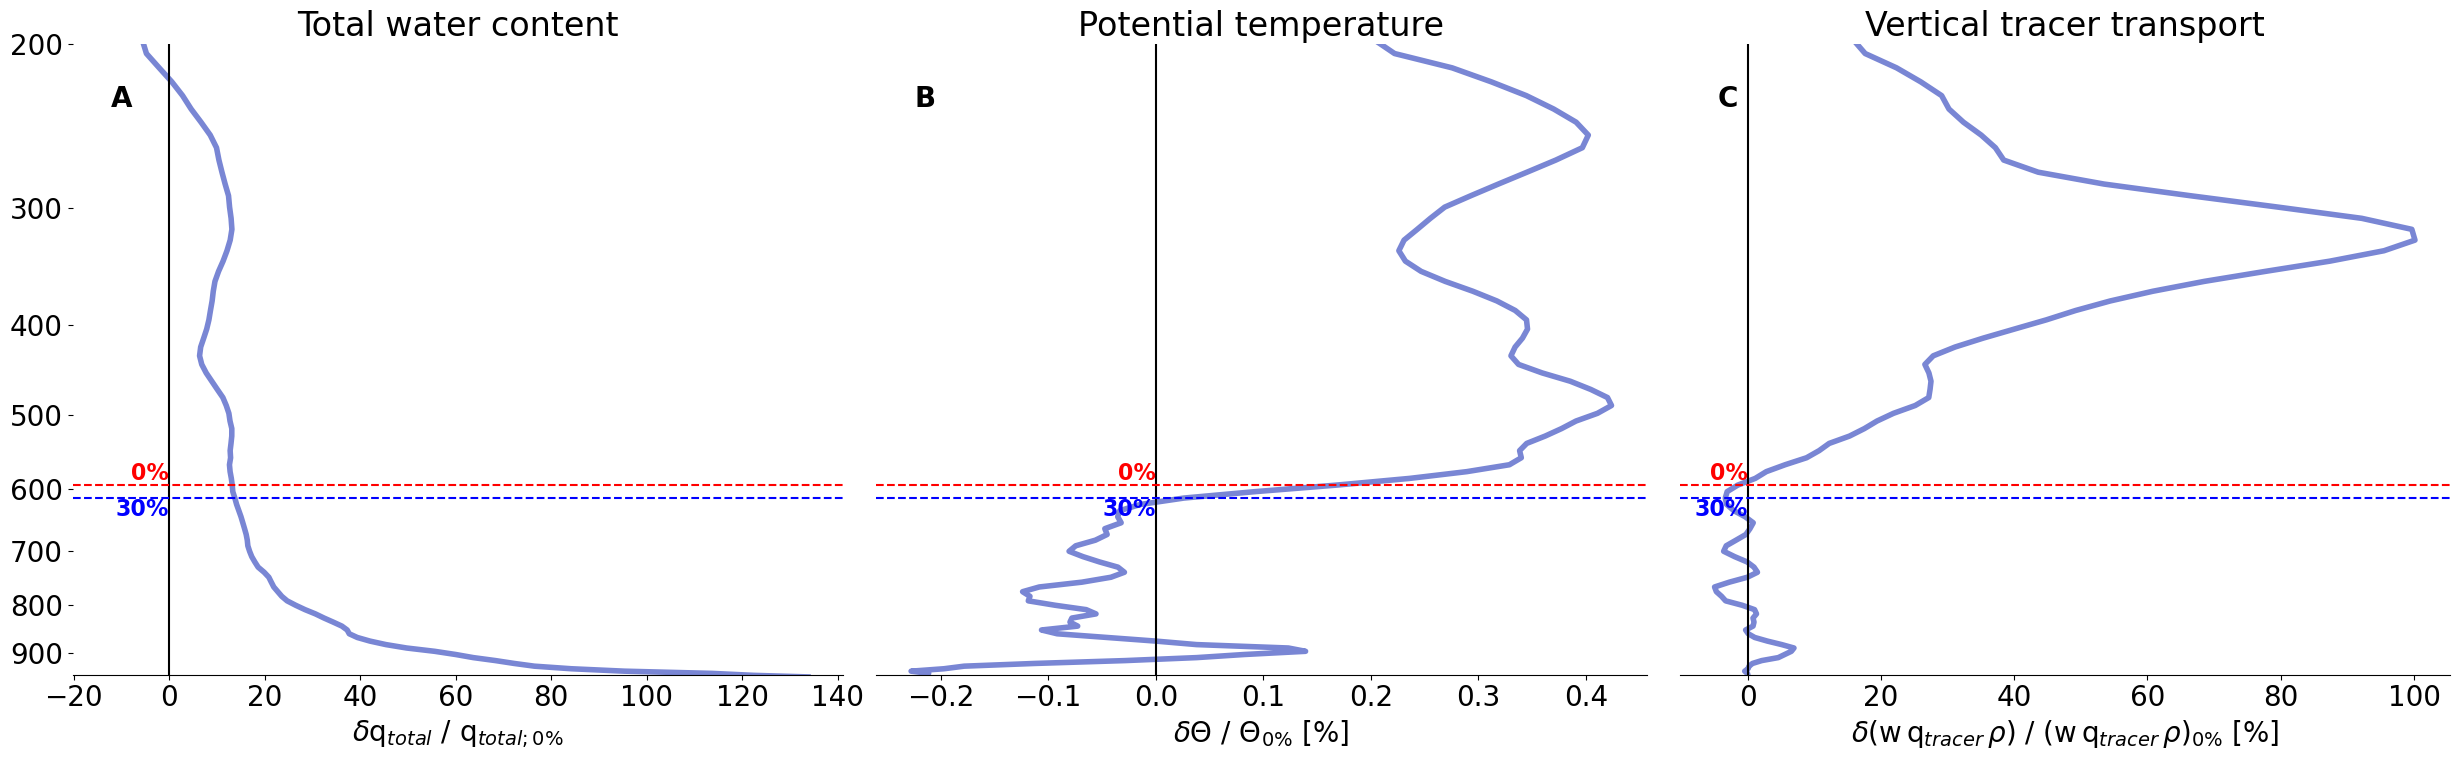

In [8]:
def setup_ax(ax, title, xlabel, y_ticks, cbase):
    ax.invert_yaxis()
    ax.set_yscale("log")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_ylim(950, 200)  # Setting y-axis limits
    ax.axvline(x=0, color="black")
    sns.despine(ax=ax, left=True)

    # Adding horizontal lines and text for cbase
    ax.axhline(y=cbase[0], color='red', linestyle='--', linewidth=1.5)
    ax.axhline(y=cbase[1], color='blue', linestyle='--', linewidth=1.5)
    ax.text(0, cbase[0], "0%", color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=16, fontweight='bold')
    ax.text(0, cbase[1], "30%", color='blue', verticalalignment='top', horizontalalignment='right', fontsize=16, fontweight='bold')
    
    # Set title and labels
    ax.set_title(title, loc='center')
    ax.set_xlabel(xlabel)

# Create the subplots
fig, ax = plt.subplots(1, 3, figsize=(25, 8), sharey=True)

# Define plot data and labels
plot_data = [
    (rel_q, "Total water content", r"$\delta$q$_{{total}}$ / q$_{{total; 0\%}}$"),
    (rel_tpot, "Potential temperature", r"$\delta\Theta$ / $\Theta_{{0\%}}$ [%]"),
    (rel_tracer, "Vertical tracer transport", r"$\delta$(w$\,$q$_{{tracer}}\,\rho$) / (w$\,$q$_{{tracer}}\,\rho)_{{0\%}}$ [%]")
]

# Set common y-ticks for all subplots
y_ticks = [900, 800, 700, 600, 500, 400, 300, 200]

# Loop through each axis and plot the data
for i, (data, title, xlabel) in enumerate(plot_data):
    ax[i].plot(data, data['height'], linewidth=4, color="#7986d4")
    setup_ax(ax[i], title, xlabel, y_ticks, cbase)
    if i > 0:
        ax[i].yaxis.set_visible(False)  # Hide y-axis for non-first plots

# Add subplot labels
for i, axis in enumerate(ax):
    axis.text(0.05, 0.9, f"{chr(65 + i)}", fontsize=20, fontweight="bold", transform=axis.transAxes)

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure
my_path = "./figs/"
fig.savefig(my_path + 'fig07.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig07_lq.png', dpi=50, bbox_inches='tight')
